# Определение стоимости автомобилей

Разработка модели машинного обучения, способной определять рыночную стоимость автомобиля основываясь на данных о технических характеристиках, комлектации и цене, для сервиса по продаже автомобилей с пробегом "Не бит, не крашен". Модель должна соответствовать следующим требованиям заказчика:

 * Высокое качество предсказания;
 * Высокая скорость предсказания;
 * Небольшое время обучения модели.
 
**Ход исследования:**

* Загрузка данных и изучение общей информации;
* Подговка данных к работе:
    * Предобработка данных;
    * Кодирование признаков;
    * Масштабирование  признаков;
* Обучение разных моделей:
    * Линейная регрессия;
    * Градиентный бустинг `XGBoost`;
    * Градиентный бустинг `CatBoost`;
    * Градиентный бустинг `LightGBM`;
* Анализ скорости работы и качества моделей;
* Итоги исследования.

## Загрузка данных и изучение общей информации

In [6]:
!pip install xgboost

In [7]:
!pip install catboost

In [1]:
# подключение библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
import warnings

warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None

Прочитаем данные из файла `autos.csv`:

In [2]:
df = pd.read_csv('autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Согласно документации к данным:

**Признаки:**
* `DateCrawled` — дата скачивания анкеты из базы

* `VehicleType` — тип автомобильного кузова

* `RegistrationYear` — год регистрации автомобиля

* `Gearbox` — тип коробки передач

* `Power` — мощность (л. с.)

* `Model` — модель автомобиля

* `Kilometer` — пробег (км)

* `RegistrationMonth` — месяц регистрации автомобиля

* `FuelType` — тип топлива

* `Brand` — марка автомобиля

* `NotRepaired` — была машина в ремонте или нет

* `DateCreated` — дата создания анкеты

* `NumberOfPictures` — количество фотографий автомобиля

* `PostalCode` — почтовый индекс владельца анкеты (пользователя)

* `LastSeen` — дата последней активности пользователя

**Целевой признак:**
 * `Price` — цена (евро)

**Вывод:**

Каждая строка датафрейма содержит информацию об одном конкретном автомобиле. Есть как числовые признаки, так и признаки типа object. Есть пропуски в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`, причем все эти признаки - категориальные. Соберем все наблюдения о признаках воедино и предварительно решим, как правильно подготовить их к работе:

| Столбец               | Значение          | Наблюдения          | Предполагаемые действия     |
| --------------------- |:------------------:|:-------------------:|:----------------------------:|
| **DateCrawled**       | Дата скачивания анкеты из базы | Признак не важен для нашей задачи (+ повторяет даты из 'DateCreated') | Исключить из признаков для обучения |
| **VehicleType**       | Тип автомобильного кузова | Есть пропуски | Заполнение категорией "unknown" | 
| **RegistrationYear**  | Год регистрации автомобиля | Есть аномальные значения (например, 8200) | Проверить долю аномальных значений и отталкиваться от этого |
| **Gearbox**       | Тип коробки передач | Есть пропуски | Заполнение категорией "unknown" | 
| **Power**       | Мощность (л. с.) | много нулевых значений | Замена медианной мощностью | 
| **Model**       | Модель автомобиля | Есть пропуски | Заполнение категорией "unknown" |
| **Kilometer**       | Пробег (км) | - | - |
| **RegistrationMonth**       | Месяц регистрации автомобиля | Много нулевых значений | - |
| **FuelType**       | Тип топлива | Есть пропуски | Заполнение категорией "unknown" |
| **Brand**       | Марка автомобиля | - | - |
| **NotRepaired**       | Была машина в ремонте или нет | Есть пропуски | Заполнение категорией "unknown" |
| **DateCreated**       | Дата создания анкеты | - | Можно оставить только месяц |
| **NumberOfPictures**       | Количество фотографий автомобиля | Содержит только нулевые значения | Исключить из признаков для обучения |
| **PostalCode**       | почтовый индекс владельца анкеты (пользователя) | Признак не важен для нашей задачи | Исключить из признаков для обучения |
| **LastSeen**       | Дата последней активности пользователя | Признак не важен для нашей задачи | Исключить из признаков для обучения |
| **Price**       | Цена (евро) | - | - |

## Подготовка данных

### Предобработка данных

Исключим из датафрейма столбцы, с которыми не будем продолжать работать, так как они избыточны и не играют роли для задачи определения стоимости автомобилей: `DateCrawled`, `PostalCode`, `LastSeen`, `NumberOfPictures`.

In [4]:
df = df.drop(['DateCrawled', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)

Переименуем названия столбцов датафрейма для более удобной работы с ними:

In [5]:
# приведение столбцов к стилю lower_case

df.columns = df.columns.str.lower()
df = df.rename(columns = {'vehicletype': 'vehicle_type', 'registrationyear': 'registration_year', 
                          'registrationmonth': 'registration_month', 'fueltype': 'fuel_type', 
                          'notrepaired': 'not_repaired', 'datecreated': 'date_created'})

Проверим, сколько пропусков содержит каждый из признаков:

In [6]:
pd.DataFrame({'Количество пропусков': df.isna().sum(), 
              'Доля пропусков (%)': round(df.isna().sum() / df.shape[0] * 100, 0)})

,Количество пропусков,Доля пропусков (%)
price,0,0.0
vehicle_type,37490,11.0
registration_year,0,0.0
gearbox,19833,6.0
power,0,0.0
model,19705,6.0
kilometer,0,0.0
registration_month,0,0.0
fuel_type,32895,9.0
brand,0,0.0


Доля пропусков каждого из признаков довольно велика: от 6% до 20%. Удалять все объекты с пропусками - не лучший вариант, так как таким образом мы потеряем большое количество данных. Можно заметить, что признаки `vehicle_type`, `gearbox`, `model` и `fuel_type` являются категориальными, поэтому пропуски в них можно заменить новой категорией `unknown` и научить модели работать и с такими данными тоже. 

Признак `not_repaired` является бинарным, однако доля пропусков у него самая большая (20%), поэтому удалять их нельзя. Рассмотрим и этот признак как категориальный и избавимся от пропусков по той же стратегии. 

In [7]:
# замена пропусков на unknown

df[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'not_repaired']] = df[
    ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'not_repaired']].fillna('unknown')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354369 non-null  int64 
 1   vehicle_type        354369 non-null  object
 2   registration_year   354369 non-null  int64 
 3   gearbox             354369 non-null  object
 4   power               354369 non-null  int64 
 5   model               354369 non-null  object
 6   kilometer           354369 non-null  int64 
 7   registration_month  354369 non-null  int64 
 8   fuel_type           354369 non-null  object
 9   brand               354369 non-null  object
 10  not_repaired        354369 non-null  object
 11  date_created        354369 non-null  object
dtypes: int64(5), object(7)
memory usage: 32.4+ MB


Осталось рассмотреть следующие признаки: `registration_year`, `power`, `registration_month` и  `date_created`. Проверим их на аномальные значения и решим, как с ними поступить.  

Начнем с признака года регистрации автомобилей `registration_year`:

In [8]:
df['registration_year'].describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

In [9]:
df[(df['registration_year'] < 1900) | (df['registration_year'] > 2019)]['registration_year'].count()

171

Есть как аномально маленькие, так и аномально большие значения, однако их всего 171, что составляет менее 0.001% от всех данных, поэтому такие объекты можно удалить из датафрейма.  

In [10]:
df = df[(df['registration_year'] > 1900) & (df['registration_year'] < 2019)]

Теперь рассмотрим признак `power`. Здесь очень много нулевых значений, причиной которым может быть то, что пользователь не указал мощность автомобиля в анкете. В таком случае эти значения можно считать пропусками и заменить их медианным значением. 

In [11]:
# заполнение пропусков медианными значениями в зависимости от модели, 
# марки автомобиля и типа топлива

df['power'] = df['power'].replace(0, np.nan)
median = df.groupby(['model', 'fuel_type', 'brand'])['power'].transform('median')
df['power'] = df['power'].fillna(median)

Оставшиеся пропуски можно удалить из таблицы, так как их количество составляет менее 0.001% от изначального числа данных. 

In [12]:
# проверка наличия пропусков в столбце с мощностью после заполнения

display(df[df['power'].isna()]['price'].count())
df.dropna(inplace=True)

98

Теперь проверим признак `power` на наличие аномалий.

(-10.0, 1000.0)

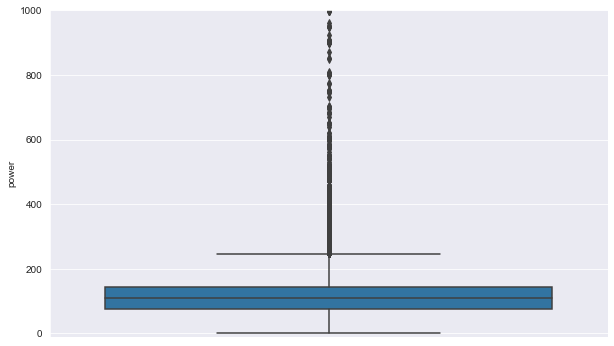

In [13]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['power'])
plt.ylim(-10, 1000)

In [14]:
df['power'].describe(percentiles=[.05, .1, .15, .25, .5, .75, .95, .98])

count    354075.000000
mean        122.062614
std         186.031534
min           1.000000
5%           54.000000
10%          60.000000
15%          67.000000
25%          75.000000
50%         109.000000
75%         144.000000
95%         218.000000
98%         260.000000
max       20000.000000
Name: power, dtype: float64

In [15]:
round(df[(df['power'] < 54) | (df['power'] > 260)]['power'].count() / df.shape[0] * 100, 1)

5.4

Мощность ниже 5% и выше 98% квантилей является аномальной, а доля таких значений составляет около 5.4% от общего числа данных. Удалим эти аномальные значения из данных.

In [16]:
# удаление аномальных значений мощности двигателя

df = df[(df['power'] > 54) & (df['power'] < 260)]

Особенность признака `registration_month` в том, что в нем много нулевых значений, однако совершать над ними какие-либо преобразования пока что не будем и попробуем обучить модели, не трогая нули в этом столбце. 

Рассмотрим признак `date_created` - дату создания анкеты. Его можно привести к типу `datetime` и оставить только месяца, так как особо значимого разброса в годах там нет (только 2016 и 2015), а информация о месяце все же может иметь какое-то занчение для обучения модели. 

In [17]:
# Выделение признака месяца создания анкеты из даты

df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d %H:%M:%S')
df['date_created'] = pd.DatetimeIndex(df['date_created']).month
df = df.rename(columns = {'date_created': 'month_created'})

Признак `price` пока что никак трогать не будем, так как он является целевым. 

Проверим изменения:

In [18]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328662 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               328662 non-null  int64  
 1   vehicle_type        328662 non-null  object 
 2   registration_year   328662 non-null  int64  
 3   gearbox             328662 non-null  object 
 4   power               328662 non-null  float64
 5   model               328662 non-null  object 
 6   kilometer           328662 non-null  int64  
 7   registration_month  328662 non-null  int64  
 8   fuel_type           328662 non-null  object 
 9   brand               328662 non-null  object 
 10  not_repaired        328662 non-null  object 
 11  month_created       328662 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 32.6+ MB


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,month_created
0,480,unknown,1993,manual,90.0,golf,150000,0,petrol,volkswagen,unknown,3
1,18300,coupe,2011,manual,190.0,unknown,125000,5,gasoline,audi,yes,3
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,unknown,3
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,3
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,3
5,650,sedan,1995,manual,102.0,3er,150000,10,petrol,bmw,yes,4
6,2200,convertible,2004,manual,109.0,2_reihe,150000,8,petrol,peugeot,no,4
8,14500,bus,2014,manual,125.0,c_max,30000,8,petrol,ford,unknown,4
9,999,small,1998,manual,101.0,golf,150000,0,unknown,volkswagen,unknown,3
10,2000,sedan,2004,manual,105.0,3_reihe,150000,12,petrol,mazda,no,3


**Вывод:**

На этом этапе была проведена подготовка данных к дальнейшему обучению на них моделей.

* Исключены не важные для решения задачи определеня стоимости автомобилей признаки: `DateCrawled`, `PostalCode`, `LastSeen`, `NumberOfPictures`.

* Устранены все пропуски в данных(в том числе в категориальных признаках заменены новой категорией `unknown`).

* Устранены аномальные значения признаков.

### Кодирование категориальных признаков

Так как перед нами лежит задача регрессии - преобразуем все категориальные признаки в числовые. Для этого воспользуемся техникой порядкового кодирования **Ordinal Encoding**, так как использование прямого кодирования привело бы к сильному увеличению числа столбцов в датафрейме из-за большого количества категорий в некоторых признаках, а это возможно усложнило бы обучение моделей. 

In [19]:
# Порядковое кодирование категориальных признаков

category = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

encoder = OrdinalEncoder()
df_ordinal = pd.DataFrame(encoder.fit_transform(df[category]), index=df[category].index, columns=df[category].columns)
df_ordinal.head()

,vehicle_type,gearbox,model,fuel_type,brand,not_repaired
0,7.0,1.0,115.0,6.0,38.0,1.0
1,2.0,1.0,225.0,2.0,1.0,2.0
2,6.0,0.0,116.0,2.0,14.0,1.0
3,5.0,1.0,115.0,6.0,38.0,0.0
4,5.0,1.0,100.0,2.0,31.0,0.0


In [20]:
# перенос пробразованных категориальных признаков в главную таблицу

df[category] = df_ordinal
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,month_created
0,480,7.0,1993,1.0,90.0,115.0,150000,0,6.0,38.0,1.0,3
1,18300,2.0,2011,1.0,190.0,225.0,125000,5,2.0,1.0,2.0,3
2,9800,6.0,2004,0.0,163.0,116.0,125000,8,2.0,14.0,1.0,3
3,1500,5.0,2001,1.0,75.0,115.0,150000,6,6.0,38.0,0.0,3
4,3600,5.0,2008,1.0,69.0,100.0,90000,7,2.0,31.0,0.0,3


Теперь, когда пропусков и аномалий в данных не осталось, а категориальные признаки преобразованы в числовые, имеет смысл разделить их на обучающую, валидационную и тестовую выборки в соотношении 3:1. 

In [21]:
features = df.drop(['price'], axis=1)
target = df['price']

# выделение обучающей и тестовой выборок размером 75% и 25%
train_ft, test_ft, train_tg, test_tg = train_test_split(features, target, test_size=0.25, random_state=111)

На всякий случай проверим размеры выборок:

In [22]:
print(f'Объем обучающей выборки: {train_ft.shape[0]}')
print(f'Объем тестовой выборки: {test_ft.shape[0]}')

Объем обучающей выборки: 246496
Объем тестовой выборки: 82166


### Масштабирование признаков

Приведем признаки к одному масштабу путем стандартизации данных с помощью структуры **StandardScaler**:

In [23]:
%%time

# стандартизация данных в выборках
numeric = ['registration_year', 'power', 'kilometer']

scaler = StandardScaler()
scaler.fit(train_ft[numeric])
train_ft[numeric] = scaler.transform(train_ft[numeric])
test_ft[numeric] = scaler.transform(test_ft[numeric])

train_ft.head()

CPU times: total: 78.1 ms
Wall time: 75.8 ms


,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,month_created
259278,8.0,-0.596927,1.0,0.037869,225.0,0.571448,7,7.0,27.0,2.0,3
184432,7.0,1.736946,1.0,-0.054131,232.0,0.571448,5,6.0,24.0,0.0,3
208493,1.0,-0.047780,0.0,-0.836133,186.0,-0.753865,2,6.0,32.0,0.0,3
315582,4.0,0.364080,1.0,1.877873,115.0,0.571448,11,6.0,38.0,0.0,3
261863,4.0,0.638653,0.0,0.566870,6.0,0.571448,1,6.0,2.0,0.0,3


Теперь все признаки имеют одинаковый масштаб. 

**Вывод:**

* Категориальные признаки преобразованы в числовые с помощью порядкового кодтрования. 

* Признаки приведены к одному масштабу.

## Обучение моделей

Оценку качества моделей будем проведить с помощью метрики `RMSE`. Напишем функцию ее расчета:

In [24]:
def rmse_score(target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse

Обучим четыре модели:

 * Модель линейной регрессии;
 
 * Модель градиентного бустинга `XGBoost`;
 
 * Модель градиентного бустинга `LightGBM`;
 
 * Модель градиентного бустинга `CatBoost`.
 
Подберем для них наилучшие гиперпараметры с помощью кросс-валидации на валидационной выбрке и проверим качество их предсказаний с помощью метрики `rmse` на тестовой выборке.

In [32]:
# Кросс-валидация гиперпараметров моделей с помощью GridSearch

def CV(model, params, ft, tg):
    scorer = make_scorer(rmse_score, greater_is_better=False)
    clf = GridSearchCV(model, params, scoring=scorer, cv=3)
    display(clf.fit(ft, tg, verbose=True))
    
    return clf.best_params_, clf.best_score_

Так как процедура обучения и предсказания для всех моделей будет примерно одинакова, создадим отдельные функции, отвечающие за это и за расчет времени:

In [26]:
# функция обучения моделей и расчета времени

def fit_model(model_name, regressor, train_ft, train_tg):
    time0 = time.time()
    model = regressor
    model.fit(train_ft, train_tg)
    time_fit = round(time.time() - time0, 4)
    
    print(f'Время обучения модели {model_name}: {time_fit} секунд')
    
    return model, time_fit

In [27]:
# функция испытания моделей на валидационной выборке, проверки качества моделей и расчета времени

def pred_model(model_name, model, test_ft, test_tg):
    time0 = time.time()
    predictions = model.predict(test_ft)
    rmse = rmse_score(predictions, test_tg).round(2)
    time_pred = round(time.time() - time0, 4)
    
    print(f'RMSE для модели {model_name} на валидационной выборке: {rmse}')
    print(f'Время предсказания: {time_pred} секунд')
    
    return rmse, time_pred

### Линейная регрессия

Начнем с модели линейной регрессии. Ее гиперпараметры оставим по умолчанию, обучим на тренировойчной выборке и сделаем предсказания на тестовой выборке. 

In [53]:
# Обучение линейной регрессии

model_lr, time_fit_lr = fit_model('LinearRegression', LinearRegression(), train_ft, train_tg)

Время обучения модели LinearRegression: 0.1804 секунд


In [54]:
# Предсказания модели линейной регрессии на тестовой выборке

rmse_lr, time_pred_lr = pred_model('LinearRegression', model_lr, test_ft, test_tg)

RMSE для модели LinearRegression на валидационной выборке: 2991.06
Время предсказания: 0.014 секунд


In [55]:
# Вывод результатов обучения модели линейной регрессии

result = []

result.append({'Модель' : 'LinearRegression', 
              'Параметры': 'default', 
              'Время обучения': f'{time_fit_lr} sec', 
              'Время предсказания': f'{time_pred_lr} sec', 
              'RMSE': rmse_lr})

pd.DataFrame(result)

,Модель,Параметры,Время обучения,Время предсказания,RMSE
0,LinearRegression,default,0.1804 sec,0.014 sec,2991.06


### Градиентный бустинг XGBoost

Рассмотрим следующую модель: модель экстремального градиентного бустинга `XGBoost`

In [56]:
%%time

model_xgb = XGBRegressor(verbosity=0, n_jobs=-1, random_state=111, booster='gbtree')
    
params = {'max_depth': [4, 6, 8], 
         'n_estimators': [50, 100, 200]}

best_params_xgb, best_score_xgb = CV(model_xgb, params, train_ft, train_tg)
best_params_xgb

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max...one, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
         

CPU times: total: 15min 40s
Wall time: 4min 35s


{'max_depth': 8, 'n_estimators': 200}

In [57]:
# Обучение модели XGB c выбранными гиперпарметрами на тренировоной выборке и расчет времени

model_xgb, time_fit_xgb = fit_model('XGBoost', XGBRegressor(verbosity=0, n_jobs=-1, random_state=111, 
                                  booster='gbtree', max_depth=8, n_estmators=200), train_ft, train_tg)

Время обучения модели XGBoost: 18.8463 секунд


In [58]:
# Предсказания для тестовой выборки, расчет метрики качества и времени

rmse_xgb, time_pred_xgb = pred_model('XGBoost', model_xgb, test_ft, test_tg)

RMSE для модели XGBoost на валидационной выборке: 1693.7
Время предсказания: 0.1782 секунд


In [59]:
# Вывод результатов обучения модели XGBoost

result.append({'Модель' : 'XGBoost', 
              'Параметры': best_params_xgb, 
              'Время обучения': f'{time_fit_xgb} sec', 
              'Время предсказания': f'{time_pred_xgb} sec', 
              'RMSE': rmse_xgb})

result_df = pd.DataFrame(result)

In [60]:
result_df

,Модель,Параметры,Время обучения,Время предсказания,RMSE
0,LinearRegression,default,0.1804 sec,0.014 sec,2991.06
1,XGBoost,"{'max_depth': 8, 'n_estimators': 200}",18.8463 sec,0.1782 sec,1693.70


### Градиентный бустинг CatBoost

Обучим модель градиентного бустинга `CatBoost`. 

In [61]:
%%time

model_cat = CatBoostRegressor(random_state=111, verbose=False)

params = {'iterations': [50, 100, 200], 
         'depth': [4, 6, 8],
         'l2_leaf_reg': [1, 3, 5]}

result_gs_cat = model_cat.grid_search(params, X=train_ft, y=train_tg, verbose=False)


bestTest = 2836.209978
bestIteration = 49


bestTest = 2832.283814
bestIteration = 49


bestTest = 2832.510245
bestIteration = 49


bestTest = 2310.232152
bestIteration = 99


bestTest = 2305.856612
bestIteration = 99


bestTest = 2307.786444
bestIteration = 99


bestTest = 2093.164066
bestIteration = 199


bestTest = 2090.880047
bestIteration = 199


bestTest = 2091.493292
bestIteration = 199


bestTest = 2685.583888
bestIteration = 49


bestTest = 2688.037542
bestIteration = 49


bestTest = 2689.164612
bestIteration = 49


bestTest = 2160.656238
bestIteration = 99


bestTest = 2160.335294
bestIteration = 99


bestTest = 2160.626077
bestIteration = 99


bestTest = 1964.554201
bestIteration = 199


bestTest = 1968.651937
bestIteration = 199


bestTest = 1964.264694
bestIteration = 199


bestTest = 2594.111231
bestIteration = 49


bestTest = 2595.848454
bestIteration = 49


bestTest = 2596.716714
bestIteration = 49


bestTest = 2064.766846
bestIteration = 99


bestTest = 2067.163838
be

Лучшими гиперпараметрами стали:

In [62]:
display(model_cat.get_params())
model_cat.get_best_score()

{'loss_function': 'RMSE',
 'verbose': False,
 'random_state': 111,
 'depth': 8,
 'l2_leaf_reg': 3,
 'iterations': 200}

{'learn': {'RMSE': 1895.0632141741087}}

Обучим модель `CatBoost` с подобранными гиперпараметрами на тренировочной выборке:

In [63]:
# Обучение модели CatBoost c выбранными гиперпарметрами на тренировоной выборке и расчет времени

model_cat, time_fit_cat = fit_model('CatBoost', CatBoostRegressor(
    random_state=111, loss_function='RMSE', depth=8, l2_leaf_reg=3, iterations=200, verbose=0), 
                                train_ft, train_tg)

Время обучения модели CatBoost: 8.2384 секунд


И узнаем качество нашей модели на тестовой выборке:

In [64]:
# Предсказания для валидационной выборки, расчет метрики качества и времени

rmse_cat, time_pred_cat = pred_model('CatBoost', model_cat, test_ft, test_tg)

RMSE для модели CatBoost на валидационной выборке: 1916.48
Время предсказания: 0.0369 секунд


In [65]:
# Вывод результатов обучения модели CatBoost

result.append({'Модель' : 'CatBoost', 
              'Параметры': model_cat.get_params(), 
              'Время обучения': f'{time_fit_cat} sec', 
              'Время предсказания': f'{time_pred_cat} sec', 
              'RMSE': rmse_cat})

result_df = pd.DataFrame(result)

In [66]:
result_df

,Модель,Параметры,Время обучения,Время предсказания,RMSE
0,LinearRegression,default,0.1804 sec,0.014 sec,2991.06
1,XGBoost,"{'max_depth': 8, 'n_estimators': 200}",18.8463 sec,0.1782 sec,1693.70
2,CatBoost,"{'iterations': 200, 'depth': 8, 'l2_leaf_reg':...",8.2384 sec,0.0369 sec,1916.48


### Градиентный бустинг LightGBM

И последней рассмотренной моделью станет модель градиентного бустинга `LightGBM`.

In [67]:
%%time

model_lgbm = LGBMRegressor(random_state=111)

params = {'max_depth': [4, 6, 8], 
         'n_estimators': [50, 100, 200], 
         'learning_rate': [0.1, 0.03]}

best_params_lgbm, best_score_lgbm = CV(model_lgbm, params, train_ft, train_tg)
best_params_lgbm

GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=111),
             param_grid={'learning_rate': [0.1, 0.03], 'max_depth': [4, 6, 8],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(rmse_score, greater_is_better=False))

CPU times: total: 4min 41s
Wall time: 1min 16s


{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}

Проведем обучение модели `LightGBM` с подобранными гиперпараметрами на тренировочной выборке:

In [68]:
# Обучение модели LightGBM c выбранными гиперпарметрами на тренировоной выборке и расчет времени

model_lgbm, time_fit_lgbm = fit_model('LightGBM', LGBMRegressor(random_state=111, 
                                                           learning_rate=0.1, max_depth=8, n_estimators=200), 
                                 train_ft, train_tg)

Время обучения модели LightGBM: 2.4016 секунд


Теперь опробуем обученную модель на валидационной выборке и узнаем ее качество:

In [69]:
# Предсказания для тестовой выборки, расчет метрики качества и времени

rmse_lgbm, time_pred_lgbm = pred_model('LightGBM', model_lgbm, test_ft, test_tg)

RMSE для модели LightGBM на валидационной выборке: 1758.0
Время предсказания: 0.51 секунд


In [70]:
# Вывод результатов обучения модели LightGBM

result.append({'Модель' : 'LightGBM', 
              'Параметры': best_params_lgbm, 
              'Время обучения': time_fit_lgbm, 
              'Время предсказания': time_pred_lgbm, 
              'RMSE': rmse_lgbm})

pd.DataFrame(result)

,Модель,Параметры,Время обучения,Время предсказания,RMSE
0,LinearRegression,default,0.1804 sec,0.014 sec,2991.06
1,XGBoost,"{'max_depth': 8, 'n_estimators': 200}",18.8463 sec,0.1782 sec,1693.70
2,CatBoost,"{'iterations': 200, 'depth': 8, 'l2_leaf_reg':...",8.2384 sec,0.0369 sec,1916.48
3,LightGBM,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",2.4016,0.51,1758.00


## Анализ моделей

In [71]:
pd.DataFrame({'Модель': ['LinearModel', 'XGBoost', 'CatBoost', 'LightGBM'], 
             'Время обучения': [time_fit_lr, time_fit_xgb, time_fit_cat, time_fit_lgbm], 
             'Время предсказания': [time_pred_lr, time_pred_xgb, time_pred_cat, time_pred_lgbm], 
             'RMSE': [rmse_lr, rmse_xgb, rmse_cat, rmse_lgbm]})

,Модель,Время обучения,Время предсказания,RMSE
0,LinearModel,0.1804,0.0140,2991.06
1,XGBoost,18.8463,0.1782,1693.70
2,CatBoost,8.2384,0.0369,1916.48
3,LightGBM,2.4016,0.5100,1758.00


* По значению метрики `RMSE` лучший результат показала модель градиентного бустинга `XGBoost`, однако на ее обучение потребовалось чуть больше времени по сравнению с остальными моделями.

* Самую высокую скорость обучения показала модель линейной регрессии, однако качество у нее наихудшее. Второй по скорости обучения моделью стала модель градиентного бустинга `LightGBM`, причем по качеству эта модель находится на втором месте после модели `XGBoost`.

* По скорости предсказания лучший результат показала модель линейной регрессии, а на втором месте оказалась модел градиентного бустинга `CatBoost`.

Конкурентами за место лучшей модели стали `XGBoost` и `LightGBM`. Выбор между ними стоит делать на основе того, какой из критериев более важен: затраченное время на обучения или же качество. В том случае, если на первом месте стоит качество предсказаний модели - стоит выбрать модель `XGBoost`, хотя она и тратит на обучение чуть больше времени. Если же важнее всего скорость - стоит выбрать модель `LightGBM`, тем более что по качеству она почти уступает модели `XGBoost`.

Проверим эти две модели на адекватность в сравнении с константной моделью. 

In [72]:
# проверка с константной моделью
constant_model = DummyRegressor(strategy='median').fit(train_ft, train_tg)
constant_predictions = constant_model.predict(test_ft)
const_result = rmse_score(test_tg, constant_predictions)
print(f'\nRMSE константной модели: {round(const_result, 2)}')

print(f'\nRMSE модели XGBoost на тестовой выборке: {rmse_xgb}')
print(f'RMSE модели LightGBM на тестовой выборке: {rmse_lgbm}')


RMSE константной модели: 4722.68

RMSE модели XGBoost на тестовой выборке: 1693.7
RMSE модели LightGBM на тестовой выборке: 1758.0


Проверку на адекватность наши модели тоже прошли. 

## Итоги исследования

Итак, в ходе исследования удалось обучить и проверить в деле четыре разных модели: LinearRegression, XGBoost, CatBoost, LightGBM.

Каждая из моделей показала хорошие результаты хотя бы по одному из необходимых критериев, однако наиболее подходящими требованиям заказчика все же оказались модели градиентного бустинга **XGBoost** (лучшая по качеству) и **LightGBM** (лучшая по скорости обучения). 